# 4次元配列

In [1]:
import numpy as np

In [2]:
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [3]:
x[0].shape

(1, 28, 28)

In [4]:
x[1].shape

(1, 28, 28)

In [5]:
x[0,0]

array([[0.65187362, 0.60012904, 0.26511624, 0.85292039, 0.80469193,
        0.81274199, 0.4212184 , 0.87862456, 0.64918199, 0.90080697,
        0.86267839, 0.50647874, 0.68340596, 0.98047985, 0.79272677,
        0.89297075, 0.03173133, 0.52021665, 0.01609955, 0.18907944,
        0.45985151, 0.74087631, 0.24270066, 0.29802283, 0.05582333,
        0.51486396, 0.51612213, 0.77655281],
       [0.96456354, 0.66310013, 0.46156303, 0.022993  , 0.54205346,
        0.18652981, 0.43245519, 0.01321801, 0.62567453, 0.19089897,
        0.22184716, 0.77320514, 0.17378537, 0.23738171, 0.01249535,
        0.18067213, 0.33862731, 0.98894675, 0.12368202, 0.45759079,
        0.18065866, 0.10463561, 0.93816261, 0.15183173, 0.08486916,
        0.56931042, 0.98933188, 0.32796176],
       [0.30638862, 0.47945884, 0.24983422, 0.71458711, 0.86186869,
        0.53772597, 0.41917591, 0.92895879, 0.44730243, 0.07263784,
        0.86326246, 0.13803531, 0.0121952 , 0.36629033, 0.28085049,
        0.1734872 , 0.2534

# im2colによる展開

    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """

In [6]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [7]:
x1 = np.random.rand(1, 3, 7, 7)
col1= im2col(x1, 5, 5, stride=1, pad=0)
col1.shape

(9, 75)

In [8]:
x2 = np.random.rand(10, 3, 7, 7)
col2= im2col(x2, 5, 5, stride=1, pad=0)
col2.shape

(90, 75)

# Convolutionレイヤの実装

In [9]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride =stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW)/ self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

# Poolingレイヤの実装

In [10]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        out = np.max(col, axis=1)
        
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

参考ホームページ<br>
https://www.anarchive-beta.com/entry/2020/08/26/180000

In [30]:
import sys, os
sys.path.append(os.pardir)

import matplotlib.pyplot as plt

from collections import OrderedDict
from common.layers import *
from common.optimizer import *

# MNISTデータセット読み込み関数
from dataset.mnist import load_mnist

In [24]:
class SimpleConvNet:
    
    # インスタンス変数の定義
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num'] # フィルター数
        filter_size = conv_param['filter_size'] # フィルタの縦横
        filter_pad = conv_param['pad'] # パディング
        filter_stride = conv_param['stride'] # ストライド
        input_size = input_dim[1] # 入力データの縦横
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1 # Convレイヤの出力の縦横 
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2)) # Poolレイヤの出力の縦横

        # パラメータの初期値を設定
        self.params = {} # 初期化
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        ## レイヤを格納したディクショナリ変数を作成
        self.layers = OrderedDict() # 順番付きディクショナリ変数を初期化
        
        # 第1層
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        
        # 第2層
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        
        # 第3層
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss() # 最終層の活性化レイヤと損失関数レイヤは別のインスタンス変数とする
    
    # 推論メソッドの定義
    def predict(self, x):
        # レイヤごとに順伝播の処理:(未正規化)
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    # 損失関数メソッドの定義
    def loss(self, x, t):
        # CNNの処理:(未正規化)
        y = self.predict(x)
        
        # ソフトマックス関数による正規化と交差エントロピー誤差の計算
        return self.last_layer.forward(y, t)
    
    # 認識精度測定メソッドの定義
    def accuracy(self, x, t, batch_size=100):
        # 正解データのインデックスを取得
        if t.ndim != 1 : # one-hot表現のとき
            t = np.argmax(t, axis=1)
        
        # 認識精度を初期化
        acc = 0.0
        
        # バッチデータごとに測定
        for i in range(int(x.shape[0] / batch_size)):
            # バッチデータに切り分け
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            
            # 推論処理:(未正規化)
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            
            # 認識精度を計算・記録
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]
    
    # 勾配計算メソッドの定義
    def gradient(self, x, t):
        # 交差エントロピー誤差を計算:順伝播
        self.loss(x, t)

        ## 各パラメータに関する勾配を計算:逆伝播
        dout = 1 # 逆伝播の入力
        dout = self.last_layer.backward(dout) # 最終層の出力
        
        # 各レイヤを逆順に処理
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 各パラメータに関する勾配を保存
        grads = {} # 初期化
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
    
    # 学習後のパラメータを書き出し
    def save_params(self, file_name="params.pkl"):
        # パラメータを格納
        params = {}
        for key, val in self.params.items():
            params[key] = val
        
        # 書き出し
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)
    
    # 学習済みパラメータを読み込み
    def load_params(self, file_name="params.pkl"):
        # 読み込み
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        
        # インスタンス変数に格納
        for key, val in params.items():
            self.params[key] = val
        
        # 各レイヤのインスタンス変数に格納
        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [25]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=False, one_hot_label=True)
print(x_train.shape) # 訓練画像
print(t_train.shape) # 訓練ラベル
print(x_test.shape) # テスト画像
print(t_test.shape) # テストラベル

(60000, 1, 28, 28)
(60000, 10)
(10000, 1, 28, 28)
(10000, 10)


In [26]:
# 全データに対する試行回数を指定
max_epochs = 10

# ミニバッチサイズを指定
batch_size = 100

# 訓練データ数
train_size = x_train.shape[0]

# 全データに対するミニバッチデータの割合
iter_per_epoch = max(train_size / batch_size, 1)
print(iter_per_epoch)

# ミニバッチデータに対する試行回数を計算
max_iters = int(max_epochs * iter_per_epoch) + 1
print(max_iters)

600.0
6001


In [27]:
network = SimpleConvNet(
    input_dim=(1, 28, 28), 
    conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1}, 
    hidden_size=100, 
    output_size=10, 
    weight_init_std=0.01
)

# 最適化手法のインスタンスを作成
optimizer = Adam(lr=0.001)

In [28]:
# エポックあたりの試行回数のカウントを初期化
epoch_cnt = 0

# 精度記録用リストを初期化
train_acc_list = []
test_acc_list = []
train_loss_list = []

# ミニバッチデータごとに学習
for i in range(max_iters):
    
    # ランダムにバッチデータ抽出
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配を計算
    grads = network.gradient(x_batch, t_batch)
    
    # パラメータを更新
    optimizer.update(network.params, grads)
    
    # 交差エントロピー誤差を記録
    train_loss = network.last_layer.loss
    train_loss_list.append(train_loss)
    
    # (動作確認も兼ねて)交差エントロピー誤差を表示
    if i % 100 == 0:
        print("iter:" + str(i) + ", train loss:" + str(np.round(train_loss, 3)))
    
    # 1エポックごとに認識精度を測定
    if i % iter_per_epoch == 0:
        # 精度を測定
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        
        # 値を記録
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        # (動作確認も兼ねて)認識精度を表示
        print(
            "===========" + "epoch:" + str(epoch_cnt) + "===========" + 
            "\ntrain acc:" + str(np.round(train_acc, 3)) + 
            "\ntest acc :" + str(np.round(test_acc, 3))
        )
        
        # エポックあたりの試行回数をカウント
        epoch_cnt += 1

iter:0, train loss:2.303
===========epoch:0===========
train acc:0.208
test acc :0.208
iter:100, train loss:0.397
iter:200, train loss:0.239
iter:300, train loss:0.234
iter:400, train loss:0.279
iter:500, train loss:0.103
iter:600, train loss:0.083
===========epoch:1===========
train acc:0.961
test acc :0.962
iter:700, train loss:0.087
iter:800, train loss:0.14
iter:900, train loss:0.103
iter:1000, train loss:0.093
iter:1100, train loss:0.164
iter:1200, train loss:0.043
===========epoch:2===========
train acc:0.977
test acc :0.977
iter:1300, train loss:0.069
iter:1400, train loss:0.058
iter:1500, train loss:0.05
iter:1600, train loss:0.016
iter:1700, train loss:0.019
iter:1800, train loss:0.052
===========epoch:3===========
train acc:0.983
test acc :0.98
iter:1900, train loss:0.013
iter:2000, train loss:0.02
iter:2100, train loss:0.027
iter:2200, train loss:0.059
iter:2300, train loss:0.027
iter:2400, train loss:0.016
===========epoch:4===========
train acc:0.987
test acc :0.985
iter:2

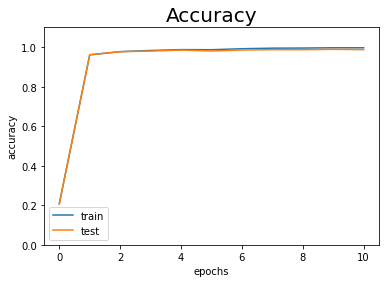

In [31]:
# x軸の値を生成
epochs = np.arange(len(train_acc_list))

# 作図
plt.plot(epochs, train_acc_list, label='train') # 訓練データ
plt.plot(epochs, test_acc_list, label='test') # テストデータ
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("accuracy") # y軸ラベル
plt.ylim(0, 1.1) # y軸の範囲
plt.legend() # 凡例
plt.title("Accuracy", fontsize=20) # タイトル
plt.show()

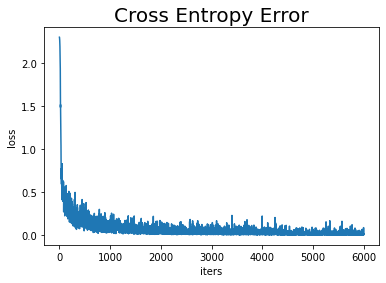

In [32]:
# x軸の値を生成
iters = np.arange(len(train_loss_list))

# 作図
plt.plot(iters, train_loss_list, label='train') # 訓練データ
plt.xlabel("iters") # x軸ラベル
plt.ylabel("loss") # y軸ラベル
plt.title("Cross Entropy Error", fontsize=20) # タイトル
plt.show()